### NLPExplainer on IMDB dataset

The class `NLPExplainer` is designed for NLP tasks, acting as a factory of the supported NLP explainers such as integrated-gradient and LIME. `NLPExplainer` provides a unified easy-to-use interface for all the supported explainers. Because the supported NLP explainers in the current version are limited, one can either use `NLPExplainer` or a specific explainer in the package `omnixai.explainers.nlp` to generate explanations.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [4]:
import sys
import os

module_path = os.path.abspath('E:/Codes/OmniXAI/omnixai/')
if module_path not in sys.path:
    sys.path.append(module_path)

# For Jupyter notebooks or interactive environments where __file__ is not defined
try:
    # Try to use __file__ if available
    directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If __file__ is not defined (e.g., in Jupyter), use the current working directory
    directory = os.path.abspath('')
    
sys.path.append(os.path.dirname(directory))

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sklearn
from sklearn.datasets import fetch_20newsgroups

from omnixai.data.text import Text
from omnixai.preprocessing.text import Word2Id
from omnixai.explainers.tabular.agnostic.L2X.utils import Trainer, InputData, DataLoader
from omnixai.explainers.nlp import NLPExplainer
from omnixai.visualization.dashboard import Dashboard

We apply a simple CNN model for this text classification task. Note that the method `forward` has two inputs `inputs` (token ids) and `masks` (the sentence masks). Note that the first input of the model must be the token ids.

In [6]:
class TextModel(nn.Module):

    def __init__(self, num_embeddings, num_classes, **kwargs):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_size = kwargs.get("embedding_size", 50)
        self.embedding = nn.Embedding(self.num_embeddings, self.embedding_size)
        self.embedding.weight.data.normal_(mean=0.0, std=0.01)
        
        hidden_size = kwargs.get("hidden_size", 100)
        kernel_sizes = kwargs.get("kernel_sizes", [3, 4, 5])
        if type(kernel_sizes) == int:
            kernel_sizes = [kernel_sizes]

        self.activation = nn.ReLU()
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(self.embedding_size, hidden_size, k, padding=k // 2) for k in kernel_sizes])
        self.dropout = nn.Dropout(0.2)
        self.output_layer = nn.Linear(len(kernel_sizes) * hidden_size, num_classes)

    def forward(self, inputs, masks):
        embeddings = self.embedding(inputs)
        x = embeddings * masks.unsqueeze(dim=-1)
        x = x.permute(0, 2, 1)
        x = [self.activation(layer(x).max(2)[0]) for layer in self.conv_layers]
        outputs = self.output_layer(self.dropout(torch.cat(x, dim=1)))
        if outputs.shape[1] == 1:
            outputs = outputs.squeeze(dim=1)
        return outputs

A `Text` object is used to represent a batch of texts/sentences. The package `omnixai.preprocessing.text` provides some transforms related to text data such as `Tfidf` and `Word2Id`.

In [ ]:
# Load the training and test datasets
train_data = pd.read_csv('/home/ywz/data/imdb/labeledTrainData.tsv', sep='\t')
n = int(0.8 * len(train_data))
x_train = Text(train_data["review"].values[:n])
y_train = train_data["sentiment"].values[:n].astype(int)
x_test = Text(train_data["review"].values[n:])
y_test = train_data["sentiment"].values[n:].astype(int)
class_names = ["negative", "positive"]
# The transform for converting words/tokens to IDs
transform = Word2Id().fit(x_train)

The preprocessing function converts a batch of texts into token IDs and the masks. The outputs of the preprocessing function must fit the inputs of the model.

In [5]:
max_length = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

def preprocess(X: Text):
    samples = transform.transform(X)
    max_len = 0
    for i in range(len(samples)):
        max_len = max(max_len, len(samples[i]))
    max_len = min(max_len, max_length)
    inputs = np.zeros((len(samples), max_len), dtype=int)
    masks = np.zeros((len(samples), max_len), dtype=np.float32)
    for i in range(len(samples)):
        x = samples[i][:max_len]
        inputs[i, :len(x)] = x
        masks[i, :len(x)] = 1
    return inputs, masks

We now train the CNN model and evaluate its performance.

In [6]:
model = TextModel(
    num_embeddings=transform.vocab_size,
    num_classes=len(class_names)
).to(device)

Trainer(
    optimizer_class=torch.optim.AdamW,
    learning_rate=1e-3,
    batch_size=128,
    num_epochs=10,
).train(
    model=model,
    loss_func=nn.CrossEntropyLoss(),
    train_x=transform.transform(x_train),
    train_y=y_train,
    padding=True,
    max_length=max_length,
    verbose=True
)

 |████████████████████████████████████████| 100.0% Complete, Loss 0.0010


In [7]:
model.eval()
data = transform.transform(x_test)
data_loader = DataLoader(
    dataset=InputData(data, [0] * len(data), max_length),
    batch_size=32,
    collate_fn=InputData.collate_func,
    shuffle=False
)
outputs = []
for inputs in data_loader:
    value, mask, target = inputs
    y = model(value.to(device), mask.to(device))
    outputs.append(y.detach().cpu().numpy())
outputs = np.concatenate(outputs, axis=0)
predictions = np.argmax(outputs, axis=1)
print('Test accuracy: {}'.format(
    sklearn.metrics.f1_score(y_test, predictions, average='binary')))

Test accuracy: 0.8492442322991249


Similar to `TabularExplainer`, to initialize `NLPExplainer`, we need to set the following parameters:

  - `explainers`: The names of the explainers to apply, e.g., ["ig", "lime"].
  - `model`: The ML model to explain, e.g., a scikit-learn model, a tensorflow model or a pytorch model.
  - `preprocess`: The preprocessing function converting the raw data (a `Text` instance) into the inputs of model.
  - `postprocess`: The postprocessing function transforming the outputs of model to a user-specific form, e.g., the predicted probability for each class.
  - `mode`: The task type, e.g., "classification" or "regression".

The preprocessing function takes a `Text` instance as its input and outputs the processed features that the ML model consumes, e.g., the `Text` object is converted into pytorch tensors in this example.

The postprocessing function converts the outputs into class probabilities.

In [8]:
# The preprocessing function
preprocess_func = lambda x: tuple(torch.tensor(y).to(device) for y in preprocess(x))
# The postprocessing function
postprocess_func = lambda logits: torch.nn.functional.softmax(logits, dim=1)
# Initialize a NLPExplainer
explainer = NLPExplainer(
    explainers=["ig", "lime", "polyjuice"],
    mode="classification",
    model=model,
    preprocess=preprocess_func,
    postprocess=postprocess_func,
    params={"ig": {"embedding_layer": model.embedding, 
                   "id2token": transform.id_to_word}}
)

There is no "global explanation" for `NLPExplainer` currently. One can simply call explainer.explain to generate local explanations for NLP tasks.

INFO:polyjuice.polyjuice_wrapper:Setup Polyjuice.
INFO:polyjuice.polyjuice_wrapper:Setup SpaCy processor.
INFO:polyjuice.polyjuice_wrapper:Setup perplexity scorer.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Integrated gradient results:


LIME results:


Counterfactual results:


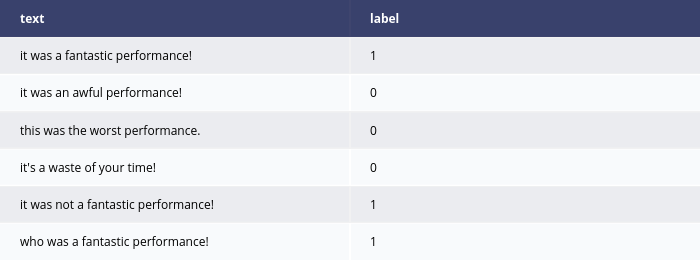

In [9]:
x = Text([
    "it was a fantastic performance!",
    "best film ever",
    "such a great show!",
    "it was a horrible movie",
    "i've never watched something as bad"
])
# Generates explanations
local_explanations = explainer.explain(x)

print("Integrated gradient results:")
local_explanations["ig"].ipython_plot(class_names=class_names)
print("LIME results:")
local_explanations["lime"].ipython_plot(class_names=class_names)
print("Counterfactual results:")
local_explanations["polyjuice"].ipython_plot()

Given the generated explanations, we can launch a dashboard (a Dash app) for visualization by setting the test instances and the generated local explanations.

In [10]:
# Launch a dashboard for visualization
dashboard = Dashboard(
    instances=x,
    local_explanations=local_explanations,
    class_names=class_names
)
dashboard.show()

Dash is running on http://127.0.0.1:8050/



INFO:omnixai.visualization.dashboard:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "omnixai.visualization.dashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
